In [4]:
import sys
import os

print(sys.version)
print(sys.path)
sys.path.insert(0, os.path.join(".."))
print(sys.path)

3.9.5 (default, Nov 23 2021, 15:27:38) 
[GCC 9.3.0]
['..', '/home/viktor/dev/receipts/python-receipt-parsing/notebooks', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/viktor/.venvs/receipt-scanning/lib/python3.9/site-packages']
['..', '..', '/home/viktor/dev/receipts/python-receipt-parsing/notebooks', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/viktor/.venvs/receipt-scanning/lib/python3.9/site-packages']


In [5]:
import os 
import json

file_name = 'kiwi.json'

receipt_dir = os.path.join('..', 'data', 'receipt_responses')
with open(os.path.join(receipt_dir, file_name)) as receipt_file:
    receipt_json = json.load(receipt_file)

{'bounding_poly': {'normalized_vertices': [], 'vertices': [{'x': 718.0, 'y': 455.0}, {'x': 1873.9504224751154, 'y': 465.7061094521879}, {'x': 1845.5644142822468, 'y': 3530.574660391832}, {'x': 689.6139918071316, 'y': 3519.868550939644}]}, 'confidence': 0, 'description': 'Salgskvittering\nKIWI KJELLER\nORG.NR. 937 846 231 MVA\nFcretaksregisteret\n13.05.23 13:30\nKvitt:314617\nSerienr.: 172529\nBANK\nMva%\n15,00\nBregnveien 2C\nTLF: 63 81 67 50\nRUCCULA G&F\n15%\nSPEKESKINKE 250G GRILST 15%\n15%\nERTER 350G FIRST PRICE\n3 x kr 10,90\n15%\n15%\n15%\n15%\nOLIVENOLJE EX. VIRGIN 0,\nSETERRØMME 35% 300G TIN\nLETTRØMME 17% 300G TINE\nLETTRØMME 17% 300G TINE\nYOGHURT TYRKISK 10% 1KG\nSMARETTSKINKE 200G GILD\nSMARETTSKINKE 200G GILD 15%\nBACON U/SVOR SKIVET 400 15%\nBACON U/SVOR SKIVET 400 15%\nURTE BASILIKLM MINIPOTT 15%\n15%\n15%\nSum 15 varer\nGrunnlag\n13.05.2023\nMva\n470,78 70,62\n13:30:35\n398021/ C01 / LA1\nTerminal: AE636784\n(P003737/AE636784)\n854358/NETSSII\nKasse: 002\nOperNr:8471\n

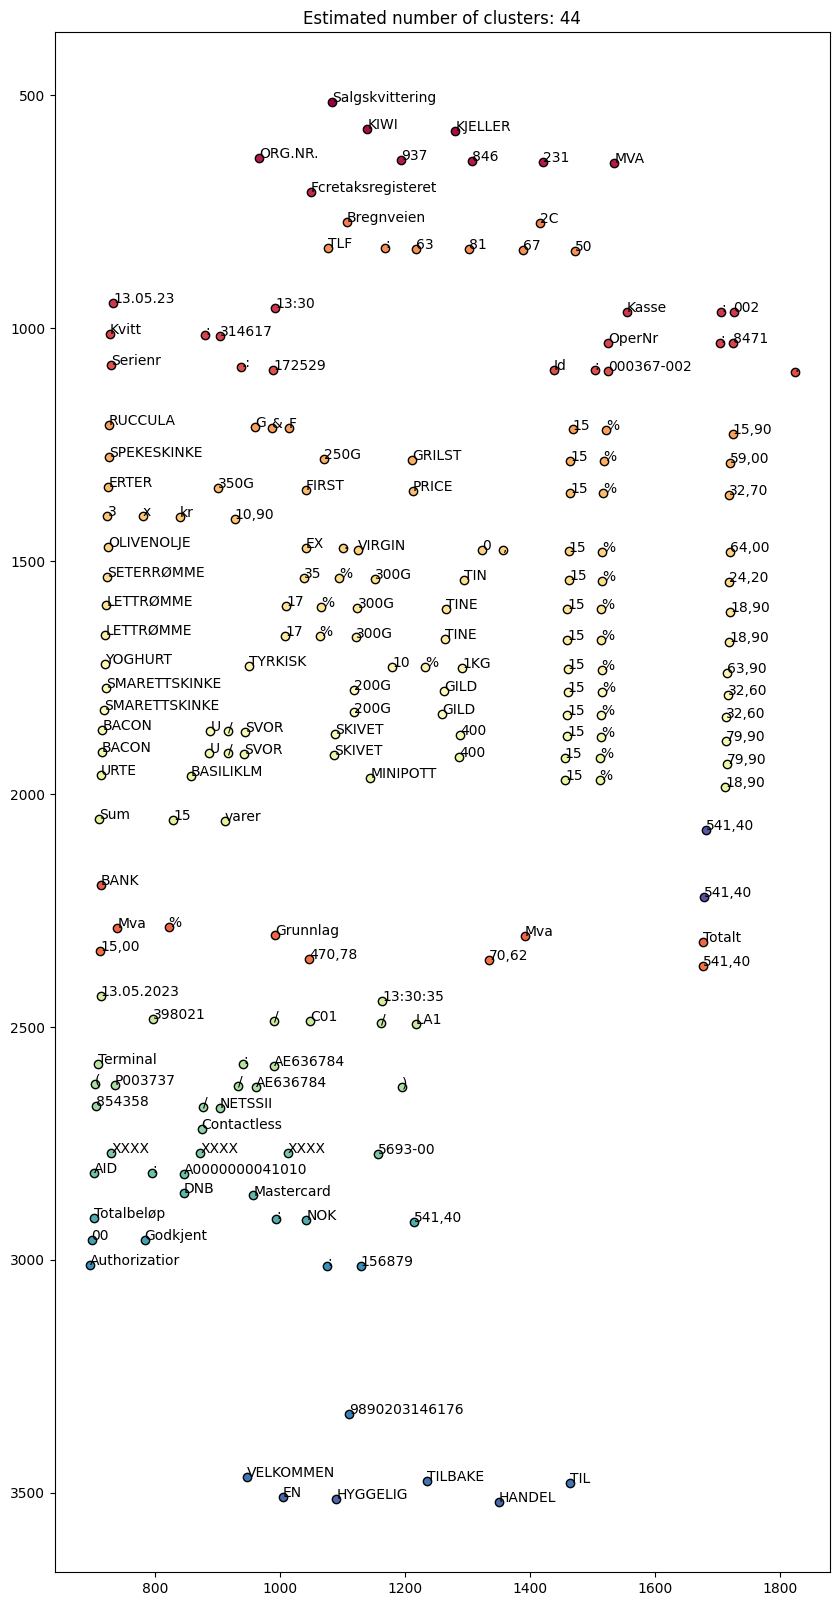

'\n\noptimal_height_factor, _ = find_optimal_height_factor(text_annotations)\noverlap_map = get_overlap_map(text_annotations, optimal_height_factor / 10)\ndistinct_overlaps = get_distinct_lists(overlap_map)\nsorted_distinct_overlaps = get_sorted_lines_by_x_axis(\n    distinct_overlaps, text_annotations\n)\nsorted_distinct_lines = get_sorted_lines_by_y_axis(\n    sorted_distinct_overlaps, text_annotations\n)\n\nreceipt = Receipt(sorted_distinct_lines, text_annotations)\n\nfor line in receipt.get_all_lines():\n    print(line.token_line)\n\n'

In [6]:
from recread.receipt.core import read_receipt_from_google_ocr_json
from recread.ocrresponses.rotation import straighten_annotations
from recread.ocrresponses.lines import (
    find_optimal_height_factor,
    get_overlap_map,
    get_sorted_lines_by_x_axis,
    get_sorted_lines_by_y_axis,
)
from recread.receipt.models import Receipt, ReceiptDbScan
from recread.util import get_distinct_lists
from copy import deepcopy

from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from recread.ocrresponses.util import get_y_height, get_y_center


text_annotations = deepcopy(receipt_json["text_annotations"])

straighten_annotations(text_annotations)

print(text_annotations[0])
print(f"annotations length: {len(text_annotations)}")

annotation_heights = [abs(a['bounding_poly']["vertices"][0]["y"] - a['bounding_poly']["vertices"][2]["y"]) for a in text_annotations]
median_height = np.median(annotation_heights)
text_annotations = [a for a in text_annotations if abs(a['bounding_poly']["vertices"][0]["y"] - a['bounding_poly']["vertices"][2]["y"]) < median_height*3]
print(f"median_height: {median_height}")
annotations_y = [sum(vert["y"] for vert in a['bounding_poly']["vertices"][2:]) / 2 for a in text_annotations]
annotations_y = list([x] for x in annotations_y)

print(annotations_y)

db_scans = []

for x in range(1, 10):
    db = DBSCAN(eps=median_height/(x/2), min_samples=1).fit(annotations_y)
    sil = metrics.silhouette_score(annotations_y, db.labels_)
    db_scans.append((db, sil))

print("db_scans")
print(db_scans)
    
db, sil = sorted(db_scans, key=lambda x: x[1], reverse=True)[0]

print(db)
print(f"Best sil factor: {sil:.3f}")

labels = db.labels_
print(f"annotations_y: {len(annotations_y)}")
print(f"labels: {len(labels)}")
print(labels)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Silhouette Coefficient: {metrics.silhouette_score(annotations_y, labels):.3f}")



unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True


lines  = {}



colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for i, label in enumerate(labels):
    if label == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    else:
        col = colors[label]

    """xy = annotations_y[i]
    plt.plot(
        0,
        xy[ 0],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )"""

    xy = annotations_y[i]
    annotation = text_annotations[i]
    plt.plot(
        annotation["bounding_poly"]["vertices"][0]["x"],
        xy[ 0],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,

    )
    plt.text(
             annotation["bounding_poly"]["vertices"][0]["x"],
        xy[ 0],
             
             text_annotations[i]["description"])
    
    if label not in lines.keys():
        lines[label] = [annotation]
    else:
        lines[label].append(annotation)

overlap_map = list(lines.values())
print("overlap_map")
print(overlap_map)
for line in overlap_map:
    line = sorted(line, key=lambda x: min(
        x["bounding_poly"]["vertices"][0]["x"],
        x["bounding_poly"]["vertices"][3]["x"],
    ))
sorted_distinct_lines = sorted(overlap_map, key=lambda x: get_y_center(x[0]["bounding_poly"]))



receipt = []
for line in sorted_distinct_lines:
    line_text = " ".join(list([x["description"] for x in line]))
    receipt.append(line_text)
    print(line_text)


plt.gca().invert_yaxis()
plt.gcf().set_size_inches((10, 20))

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

"""

optimal_height_factor, _ = find_optimal_height_factor(text_annotations)
overlap_map = get_overlap_map(text_annotations, optimal_height_factor / 10)
distinct_overlaps = get_distinct_lists(overlap_map)
sorted_distinct_overlaps = get_sorted_lines_by_x_axis(
    distinct_overlaps, text_annotations
)
sorted_distinct_lines = get_sorted_lines_by_y_axis(
    sorted_distinct_overlaps, text_annotations
)

receipt = Receipt(sorted_distinct_lines, text_annotations)

for line in receipt.get_all_lines():
    print(line.token_line)

"""

In [11]:
from recread.receipt.models import ReceiptDbScan

receipt = ReceiptDbScan(sorted_distinct_lines)


for line in receipt.get_all_lines():
    print(line.token_line)
for pro in receipt.get_all_products():
    print(pro)



['Salgskvittering']
['KIWI', 'KJELLER']
['ORG.NR.', '937', '846', '231', 'MVA']
['Fcretaksregisteret']
['Bregnveien', '2C']
['TLF', ':', '63', '81', '67', '50']
['13.05.23', '13:30', 'Kasse', ':', '002']
['Kvitt', ':', '314617', 'OperNr', ':', '8471']
['Serienr', '.:', '172529', 'Id', ':', '000367-002', '.']
['RUCCULA', 'G', '&', 'F', '15', '%', '15,90']
['SPEKESKINKE', '250G', 'GRILST', '15', '%', '59,00']
['15', '%', 'ERTER', '350G', 'FIRST', 'PRICE', '32,70']
['3', 'x', 'kr', '10,90']
['15', '%', 'OLIVENOLJE', 'EX', '.', 'VIRGIN', '0', ',', '64,00']
['15', '%', 'SETERRØMME', '35', '%', '300G', 'TIN', '24,20']
['15', '%', 'LETTRØMME', '17', '%', '300G', 'TINE', '18,90']
['15', '%', 'LETTRØMME', '17', '%', '300G', 'TINE', '18,90']
['YOGHURT', 'TYRKISK', '10', '%', '1KG', '15', '%', '63,90']
['SMARETTSKINKE', '200G', 'GILD', '15', '%', '32,60']
['SMARETTSKINKE', '200G', 'GILD', '15', '%', '32,60']
['BACON', 'U', '/', 'SVOR', 'SKIVET', '400', '15', '%', '79,90']
['BACON', 'U', '/', 'SVO